In [1]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
import scvi
import torch

import scprotvelo
from scprotvelo._utils import add_fits_branches
from scprotvelo._plotting import plot_phase_portraits

from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from statannot import add_stat_annotation

import warnings
warnings.filterwarnings('ignore')

# Protein velocity inference with veloVI

## Data Loading

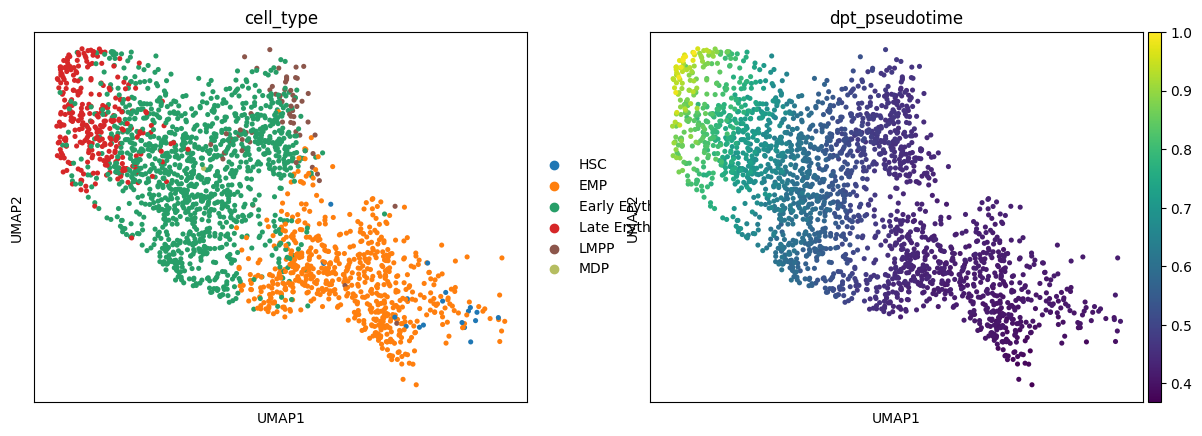

In [2]:
DATA_DIR = '/home/icb/sabrina.richter/git/scprotvelo/data/data_paired/'

adata = sc.read_h5ad(f"{DATA_DIR}paired_adata_Eryth_de_genes.h5ad")

sc.pl.umap(adata, color=['cell_type', 'dpt_pseudotime'])

In [3]:
adata.obs['dpt_pseudotime'] -= np.min(adata.obs['dpt_pseudotime'])
adata.obs['dpt_pseudotime'] /= np.max(adata.obs['dpt_pseudotime'])

In [4]:
np.random.seed(0)
test_fraction = .2

train_subset = np.random.choice(adata.obs_names, replace=False, size=int(adata.n_obs * (1 - test_fraction)))
test_subset = [o for o in adata.obs_names if o not in train_subset]
adata_train = adata[train_subset].copy()
adata_test = adata[test_subset].copy()

## Model training

In [5]:
torch.manual_seed(0)
scvi.settings.seed = 0

scprotvelo.scProtVelo.setup_anndata(
    adata_train,
    protein_layer="protein",
    rna_layer="rna",
    time_prior='dpt_pseudotime',
)

vae = scprotvelo.scProtVelo(
    adata_train, 
    time_loss_weight=100,
    kl_scaling=.01,
    penalty_scale=.2,
    kl_z_scaling=.001,
    kl_ss_scaling=0., 
    time_prior='dpt_pseudotime',
    model_steady_states=False,
    flexible_switch_time=True,
)
vae.train(
    max_epochs=2000,
    early_stopping=True,
    early_stopping_patience=70,
)

add_fits_branches(adata_train, vae)

[rank: 0] Seed set to 0


INFO     Generating sequential column names                                                                        


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1931/2000:  97%|█████████▋| 1931/2000 [06:08<00:13,  5.25it/s, v_num=1, train_loss_step=145, train_loss_epoch=123]    
Monitored metric elbo_validation did not improve in the last 70 records. Best score: 1.181. Signaling Trainer to stop.


## Evaluation

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
147
128
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Linear v.s. scProtVelo: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.449e-04 U_stat=6.019e+03


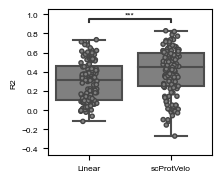

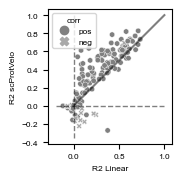

median rna: 0.312, median ode: 0.454
improvement of 45.4%


In [6]:
# subset data to only 'true' protein values/cells
adata_train_prot = adata_train[adata_train.obs['domain'] == 'protein'].copy()
adata_test_prot = adata_test[adata_test.obs['domain'] == 'protein'].copy()

# Linear
X_train_all = adata_train_prot.layers['rna'].copy()
y_train_all = adata_train_prot.layers['protein'].copy()
X_test_all = adata_test_prot.layers['rna'].copy()
y_test_all = adata_test_prot.layers['protein'].copy()

sc.pp.log1p(X_train_all)
sc.pp.log1p(X_test_all)
sc.pp.log1p(y_train_all)
sc.pp.log1p(y_test_all)

scores_rna = []
slope = []
intercept = []
for i in range(X_train_all.shape[1]):
    X_train = X_train_all[:, i].reshape(-1, 1)
    y_train = y_train_all[:, i]
    filter = y_train == y_train
    X_train = X_train[filter]
    y_train = y_train[filter]
    X_test = X_test_all[:, i].reshape(-1, 1)
    y_test = y_test_all[:, i]
    filter = y_test == y_test
    X_test = X_test[filter]
    y_test = y_test[filter]
    reg = LinearRegression().fit(X_train, y_train)
    scores_rna.append(reg.score(X_test, y_test))
    slope.append(reg.coef_[0])
    intercept.append(reg.intercept_)

# scProtVelo      
torch.manual_seed(0)
proteins, rna = vae.get_expression_fit(adata_test_prot)

protein_true_raw = adata_test_prot.layers['protein'].copy()
protein_true = sc.pp.log1p(protein_true_raw)
protein_pred = sc.pp.log1p(proteins.values)

scores_ode = []
for i in range(protein_pred.shape[1]):
    p_true = protein_true[:, i]
    filter = p_true == p_true
    p_true = p_true[filter]
    p_pred = protein_pred[:, i]
    p_pred = p_pred[filter]
    scores_ode.append(r2_score(p_true, p_pred))

# compare
adata_sub = adata_train_prot.copy()
    
adata_sub.var['r2_linear'] = scores_rna
adata_sub.var['r2_ode'] = scores_ode
adata_sub.var['slope'] = slope
adata_sub.var['intercept'] = intercept
adata_sub.var['pos slope'] = adata_sub.var['slope'] > 0

adata_sub.var['r2_diff'] = adata_sub.var['r2_ode'] - adata_sub.var['r2_linear']

adata_sub_full = adata_sub.copy()
print(adata_sub.shape[1])
adata_sub = adata_sub[:, adata_sub.var['pos slope']]
print(adata_sub.shape[1])

df = adata_sub.var[['r2_linear', 'r2_ode']]
df.columns = ['linear', 'ode']
df = df.melt()
df.columns = ['model', 'r2']

df.columns = ['Model', 'R2']
df['Model'][df['Model'] == 'linear'] = 'Linear'
df['Model'][df['Model'] == 'ode'] = 'scProtVelo'

# boxplot
with plt.rc_context({'font.family': 'Arial', 'font.size': 6}):
    plt.figure(figsize=(2.2, 1.8))
    ax = sns.boxplot(data=df, x='Model', y='R2', color='grey')

    sns.stripplot(data=df, x='Model', y='R2', edgecolor='#454545', linewidth=1, size=3, color='grey')
    ymin = np.min(df['R2']) - .2
    plt.ylim(ymin, 1.)

    add_stat_annotation(ax, data=df, x='Model', y='R2',
                        box_pairs=[("Linear", "scProtVelo")],
                        test='Mann-Whitney', text_format='star', loc='inside', verbose=2)

    plt.xlabel('')

    plt.tight_layout()
    plt.savefig('figures/r2_boxplot.pdf')
    plt.show()

adata_sub_full.var.rename(columns={'r2_linear': 'R2 Linear', 'r2_ode': 'R2 scProtVelo', 'pos slope': 'corr'}, inplace=True)
adata_sub_full.var['corr'][adata_sub_full.var['corr'] == True] = 'pos'
adata_sub_full.var['corr'][adata_sub_full.var['corr'] == False] = 'neg'

# scatterplot
with plt.rc_context({'font.family': 'Arial', 'font.size': 6}):
    plt.figure(figsize=(1.8, 1.8))
    plt.plot([0, 1], [0, 1], color='black', alpha=.5)
    plt.hlines(y=0, xmin=-.2, xmax=1, color='black', linestyle='--', linewidth=1, alpha=.5)
    plt.vlines(x=0, ymin=-.35, ymax=1, color='black', linestyle='--', linewidth=1, alpha=.5)
    sns.scatterplot(
        data=adata_sub_full.var,
        x='R2 Linear', 
        y='R2 scProtVelo',
        hue='corr', 
        style='corr', 
        palette={'pos': 'grey', 'neg': 'darkgrey'},
        s=15,
    )
    plt.axis('equal')

    plt.tight_layout()
    plt.savefig('figures/r2_scatterplot.pdf')

    plt.show()

print(f"median rna: {np.median(adata_sub.var['r2_linear']):.3f}, median ode: {np.median(adata_sub.var['r2_ode']):.3f}")
impr = (np.median(adata_sub.var['r2_ode']) / np.median(adata_sub.var['r2_linear'])) - 1
print(f"improvement of {impr * 100:.1f}%")

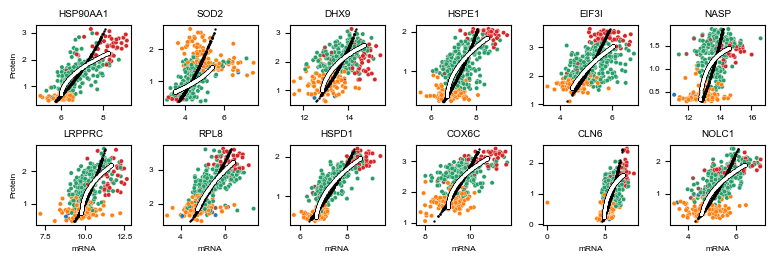

In [7]:
adata_sub_full.layers['rna_log'] = adata_sub_full.layers['rna'].copy()
sc.pp.log1p(adata_sub_full, layer='rna_log')

df = adata_sub_full.var
df = df[df['R2 Linear'] > .2]
df = df[df['R2 scProtVelo'] > .2]
df = df[df['r2_diff'] > .2]
genes = list(df['r2_diff'].sort_values(ascending=False).index)[:12]

with plt.rc_context({'font.family': 'Arial', 'font.size': 6}):
    plot_phase_portraits(
        adata_sub_full,
        genes=genes,
        n_cols=6,
        rna_layer='rna', 
        protein_layer='protein',
        figsize=(1.3, 1.3),
        show_linear_fit=True,
        save='figures/phase_portraits_comparison.pdf'
    )